## Imports 

In [1]:
import numpy as np
import scipy as sp
from time import time
import sys
sys.path.append("../")
from problem_tools.mcbh import mcbh
from scipy.linalg import null_space
from problem_tools import set_up_problem as sup
from functions import test_funcs as tf
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy, copy

## Problem set up

In [2]:
bs = 50                        # block size limit for H2 matrix
func = tf.laplace_single_layer # kernel function: Laplace single-layer potential
close_r = 1.                   # radius that defines close blocks
num_child_tree = 'hyper'       # number of children in the H2 tree 
point_based_tree = 1           # H2 tree type
eps = 1e-9                     # H2 approximation accuracy
ndim = 3                       # problem dimensionality

t0 = time()
pr = sup.build_problem(geom_type='wtorus',
                      block_size=bs,
                      func=func,
                      point_based_tree=point_based_tree,
                      close_r=close_r,
                      num_child_tree=num_child_tree,
                      file=None,
                      eps=eps, nu=55, nv=55)
print(f'problem-build time: {time() - t0}')

Number of points is 5832
problem-build time: 0.5771100521087646


In [3]:
# check
tree = pr.tree
level_count = len(tree.level) - 2
if level_count - 1 > tree.higest_leaf_lvl:
    print ("Sorry! Incomplite leaf level is under construction!")
else:
    print('Leaf lvl complete! :)')
print (f'Number of levels: {level_count-2}')

Leaf lvl complete! :)
Number of levels: 2


## Build H2

In [4]:
class Fmm(object):
    def __init__(self, pr, basis_size, basis, transfer, dot_type='t', orig = 1):
        self.u = None
        self.orig = orig
        self.pr = pr
        self.n = copy(pr.shape[0])
        tree = self.pr.tree
        size = tree.level[-1]
        self.size = size
        self.basis = basis
        self.T = transfer
        self.dot_type = dot_type
        self.index_lvl = [None for i in range(size)]
        self.rks_r = basis_size.astype(int)
        self.rks_c = basis_size.astype(int)
        self.has_close_mat = 0
    def upd_index_lvl(self, ind):
        index_size = 0
        for ch in self.pr.tree.child[ind]:
            index_size += self.basis[ch].shape[0]
        self.index_lvl[ind] = np.zeros(index_size, dtype=int)
        tmp = 0
        for ch in self.pr.tree.child[ind]:
            self.index_lvl[ind][tmp:tmp+self.basis[ch].shape[0]] = self.basis[ch]
            tmp += self.basis[ch].shape[0]
    def dot(self, tmp):
        tmp_upd = copy(tmp)
        pr = self.pr
        tree = pr.tree
        level_count = len(tree.level) - 2
        tl = self.tail_lvl
        if self.dot_type == 't':
            ans = [np.zeros(pr.shape[0])] * (level_count - tl + 1)
            ans[0] = self.dot_cl(tmp_upd)
            for i in range(level_count-1, tl-1, -1):
                tmp_upd = self.dot_T( i, tmp_upd, 'up')
                ans[level_count-i] = self.dot_il(i, tmp_upd)
            for i in range(tl, level_count):
                ans[level_count-1-i] += self.dot_T(i, ans[level_count-i], 'down')
        else:
            ans = {}
            ans[0] = self.dot_cl(tmp_upd)
            for i in range(level_count-1, tl - 1, -1):
                tmp_upd = self.dot_T(i, tmp_upd, 'up')
                ans[level_count-i] = self.dot_il(i, tmp_upd)
            for i in range(tl, level_count):
                ans_far = self.dot_T(i, ans[level_count-i], 'down')
                ans[level_count-1-i] += ans_far
        return ans[0]
    def dot_cl(self, tmp):
        pr = self.pr
        tree = self.pr.tree
        level_count = len(tree.level) - 2
        close = self.pr.close
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        if self.orig:
            for i in range(level_count-1, tree.higest_leaf_lvl-1, -1):
                job = [j for j in
                       range(tree.level[i], tree.level[i+1])]
                for ind in job:
                    for i_cl in close[ind]:
                        if not tree.child[ind] and not tree.child[i_cl]:
                            col_ind = self.index_lvl[ind]
                            row_ind = self.index_lvl[i_cl]
                            if self.has_close_mat:
                                ans[col_ind] += self.close_mat[ind,i_cl].dot(tmp[row_ind])
                            else:
                                cb = self.pr.func(col_ind, row_ind)
                                ans[col_ind] += cb.dot(tmp[row_ind])
                        elif tree.child[ind] and not tree.child[i_cl]:
                            for ch_ind in tree.child[ind]:
                                col_ind = self.index_lvl[ch_ind]
                                row_ind = self.index_lvl[i_cl]
                                if self.has_close_mat:
                                    ans[col_ind] += self.close_mat[ch_ind,i_cl].dot(tmp[row_ind])
                                else:
                                    ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
                        elif not tree.child[ind] and tree.child[i_cl]:
                             for ch_cl in tree.child[i_cl]:
                                col_ind = self.index_lvl[ind]
                                row_ind = self.index_lvl[ch_cl]
                                if self.has_close_mat:
                                    ans[col_ind] += self.close_mat[ind,ch_cl].dot(tmp[row_ind])
                                else:
                                    ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
        else:
            i = level_count - 1  
            job = [j for j in range(tree.level[i], tree.level[i+1])]
            tmp_vec_i = {}
            n_sm = 0
            ctr = 0
            for ind in job:
                n_sm += self.u[ind].shape[0]
                tmp_vec_i[ind] = copy(tmp[ctr:ctr+self.u[ind].shape[0]])
                ctr = ctr + self.u[ind].shape[0]

            atr = 0
            for ind in job:
                for i_cl in close[ind]:
                    ans[atr:atr+self.u[ind].shape[0]] += self.close_mat[ind,i_cl].dot(tmp_vec_i[i_cl])
                atr = atr + self.u[ind].shape[0]
        return ans
    def dot_il(self, i, tmp):
        il = self.pr.far
        job = [j for j in range(self.pr.tree.level[i], self.pr.tree.level[i+1])]
        if self.dot_type == 't':
            ans = np.zeros(self.n,dtype=self.pr.dtype)
            for ind in job:
                for i_il in il[ind]:
                    col_ind = self.basis[ind]
                    row_ind = self.basis[i_il]
                    if self.dot_type == 't':
                        ans[col_ind] += self.pr.func(col_ind, row_ind).dot(tmp[row_ind])
                    else:
                        ans[col_ind] += self.il_mat[ind,i_il].dot(tmp[row_ind])
        else:
            tmp_vec_i = {}
            n_sm = 0
            ctr = 0
            for ind in job:
                n_sm += self.rks_r[ind]
                tmp_vec_i[ind] = tmp[ctr:ctr+self.rks_c[ind]]
                ctr = ctr+self.rks_c[ind]
                
            ans = np.zeros(n_sm, dtype=self.pr.dtype)   
            atr = 0
            for ind in job:
#                 ctr = 0
                for i_il in il[ind]:
                    ans[atr:atr+self.rks_r[ind]] += self.il_mat[ind, i_il]@tmp_vec_i[i_il]
#                     ctr = ctr + self.rks_c[i_il]
                atr = atr + self.rks_r[ind]
        return ans
    def dot_T(self, i, tmp, prod_type):
        job = [j for j in
               range(self.pr.tree.level[i], self.pr.tree.level[i+1])]
        if self.dot_type == 't':
            for ind in job:
                if prod_type == 'up':
                    T = self.T[ind].T
                    tmp[self.basis[ind]] = T.dot(tmp[self.index_lvl[ind]])
                else:
                    T = self.T[ind]
                    tmp[self.index_lvl[ind]] = T.dot(tmp[self.basis[ind]])
        else:
            if prod_type == 'up':
                sm_n = 0
                for ind in job:
                    sm_n += self.rks_r[ind]
                ans = np.zeros(sm_n, dtype=self.pr.dtype)  
                atr = 0
                ctr = 0
                for ind in job:
                    if i == level_count - 1 and self.orig:
                        ans[atr:atr+self.u[ind].shape[1]] = self.u[ind].T.dot(tmp[tree.index[ind]])
                    else:
                        ans[atr:atr+self.u[ind].shape[1]] = self.u[ind].T.dot(tmp[ctr:ctr+self.u[ind].shape[0]])
                    ctr = ctr + self.u[ind].shape[0]
                    atr = atr + self.u[ind].shape[1]
            else:
                ctr = 0
                if i == level_count - 1 and self.orig:
                    ans = np.zeros(self.n, dtype=self.pr.dtype)
                    for ind in job:
                        ans[tree.index[ind]] = self.u[ind].dot(tmp[ctr:ctr+self.rks_r[ind]])
                        ctr = ctr + self.rks_r[ind]
                else:
                    sm_n = 0
                    for ind in job:
                        sm_n += self.u[ind].shape[0]
                    ans = np.zeros(sm_n, dtype=self.pr.dtype)
                    atr = 0
                    for ind in job:  
                        ans[atr:atr+self.u[ind].shape[0]] = self.u[ind].dot(tmp[ctr:ctr+self.rks_r[ind]])
                        ctr = ctr + self.rks_r[ind]
                        atr = atr + self.u[ind].shape[0]
            tmp = copy(ans)
        return tmp
    def dot_T_abasis(self, i, tmp, prod_type):
        job = [j for j in
               range(self.pr.tree.level[i], self.pr.tree.level[i+1])]
        if self.dot_type == 't':
            raise NameError('For this function, dot_type = u is required!')
        else:
            if prod_type == 'up':
                sm_n = 0
                for ind in job:
                    sm_n += self.index_lvl[ind].shape[0] - self.rks_r[ind]
                ans = np.zeros(sm_n, dtype=self.pr.dtype)  
                atr = 0
                ctr = 0
                for ind in job:
                    u_ns =  null_space(fmm.u[ind].T)
                    if i == level_count - 1 and self.orig:
                        ans[atr:atr+u_ns.shape[1]] = u_ns.T.dot(tmp[tree.index[ind]])
                    else:
                        ans[atr:atr+u_ns.shape[1]] = u_ns.T.dot(tmp[ctr:ctr+u_ns.shape[0]])
                    ctr = ctr + u_ns.shape[0]
                    atr = atr + u_ns.shape[1]
            else:
                ctr = 0
                if i == level_count - 1 and self.orig:
                    ans = np.zeros(self.n, dtype=self.pr.dtype)
                    for ind in job:
                        ns_size = self.index_lvl[ind].shape[0] - self.rks_r[ind]
                        u_ns =  null_space(fmm.u[ind].T)
                        ans[tree.index[ind]] = u_ns.dot(tmp[ctr:ctr+ns_size])
                        ctr = ctr + ns_size
                else:
                    sm_n = 0
                    for ind in job:
                        sm_n += self.u[ind].shape[0]
                    ans = np.zeros(sm_n, dtype=self.pr.dtype)
                    atr = 0
                    for ind in job: 
                        ns_size = self.index_lvl[ind].shape[0] - self.rks_r[ind]
                        u_ns =  null_space(fmm.u[ind].T)
                        ans[atr:atr+u_ns.shape[0]] = u_ns.dot(tmp[ctr:ctr+ns_size])
                        ctr = ctr + ns_size
                        atr = atr + self.u[ind].shape[0]
            tmp = copy(ans)
        return tmp
    def make_uv(self):
        tree = self.pr.tree
        tl = self.tail_lvl
        il = self.pr.far
        level_count = len(tree.level) - 2
        size = self.size
        self.u = [None for i in range(size)]
        self.il_mat = {}
        for i in range(level_count-1, tl-1, -1):
            job = [j for j in range(tree.level[i], tree.level[i+1])]
            pr_1 = -2
            print(f'LvL: {i}')
            for ind in job:
                pr_ind = tree.parent[ind]
                if pr_1 != pr_ind:
                    count = 0
                pr_1 = copy(pr_ind)
                if len(tree.child[ind]) == 0:
#                     sm_T = self.T[ind][:,self.local_basis[ind]]
                    sm_T = self.T[ind]
                else:
                    sm_T = copy(self.u[ind])
                u, s, v = np.linalg.svd(sm_T,full_matrices=0)
                self.u[ind] = copy(u)

                if not(self.T[pr_ind] is None):
                    if self.u[pr_ind] is None:
                        self.u[pr_ind] = copy(self.T[pr_ind])
                    self.u[pr_ind][count:count+v.shape[0],:] = np.diag(s) @ v @ self.u[pr_ind][count:count+v.shape[0],:]
                count = count + v.shape[0]
                for i_il in il[ind]:
                    if (ind, i_il) in self.il_mat:
                        self.il_mat[ind,i_il] = np.diag(s) @ v @ self.il_mat[ind,i_il]
                    else:
                        col_ind = self.basis[ind]
                        row_ind = self.basis[i_il]
                        bl = self.pr.func(col_ind, row_ind)
                        self.il_mat[ind,i_il] = np.diag(s) @ v @ bl

                    if (i_il, ind) in self.il_mat:
                        self.il_mat[i_il, ind] =  self.il_mat[i_il, ind] @ v.T @ np.diag(s) 
                    else:
                        col_ind = self.basis[i_il]
                        row_ind = self.basis[ind]
                        bl = self.pr.func(col_ind, row_ind)
                        self.il_mat[i_il, ind] = bl @ v.T @ np.diag(s) 
    def shrink_leaf_lvl(self):
        self.orig = 0
        if self.flvl == 1:
            print("Warning! Last lvl should poduce dense tilda!!!")
        tree = self.pr.tree
        close = self.pr.close
        il = self.pr.far
        level_count = len(tree.level) - 2
        i = level_count - 2
        job = [j for j in
                   range(tree.level[i], tree.level[i+1])]
        self.n = 0
        for rind in job:
            if tree.child[rind]:
                r_size = 0
                for rch in tree.child[rind]:
                    r_size += self.rks_r[rch]
            else:
                r_size = tree.index[rind].shape[0]
            self.n += r_size
            
            for cind in close[rind]:
                if tree.child[cind]:
                    c_size = 0    
                    for cch in tree.child[cind]:
                        c_size += self.rks_c[cch]  
                    cl_bl = np.zeros((r_size, c_size),dtype=self.pr.dtype)
                    if tree.child[rind]:
                        rtmp = 0
                        for rch in tree.child[rind]:
                            ctmp = 0
                            for cch in tree.child[cind]:
                                if rch in close[cch]:
                                    bl = self.u[rch].T @ self.close_mat[rch,cch] @ self.u[cch]
                                    cl_bl[rtmp : rtmp + self.rks_r[rch], ctmp : ctmp + self.rks_c[cch]] = bl
                                elif rch in il[cch]:
                                    cl_bl[rtmp : rtmp + self.rks_r[rch], ctmp : ctmp + self.rks_c[cch]] = self.il_mat[rch,cch]
                                else:
                                    print ("Bug! Wrong close!")
                                ctmp =  ctmp + self.rks_c[cch]
                            rtmp = rtmp + self.rks_r[rch]
                        self.close_mat[rind, cind] = cl_bl
                    else:
                        ctmp = 0
                        for cch in tree.child[cind]:
                            bl = self.close_mat[rind,cch] @ self.u[cch]
                            cl_bl[:, ctmp : ctmp + self.rks_c[cch]] = bl
                            ctmp =  ctmp + self.rks_c[cch]
                    self.close_mat[rind, cind] = cl_bl
                else:
                    if tree.child[rind]:
                        c_size = tree.index[cind].shape[0]
                        cl_bl = np.zeros((r_size, c_size))
                        rtmp = 0
                        for rch in tree.child[rind]:
                            bl = self.u[rch].T @ self.close_mat[rch,cind]
                            cl_bl[rtmp : rtmp + self.rks_r[rch]] = bl
                            rtmp =  rtmp + self.rks_r[rch]
                        self.close_mat[rind, cind] = cl_bl                    
        i = level_count - 1
        job = [j for j in range(tree.level[i], tree.level[i+1])]
        for rind in job:
            if self.orig:
                for cind in job:
                    del self.il_mat[rind, cind]
            else: 
                for cind in il[rind]:
                    del self.il_mat[rind, cind]
            for cind in close[rind]:
                del self.close_mat[rind, cind]
#         for ind in job:
#             tree.child[ind] = []
        self.flvl = self.flvl - 1                    
        tree.level[-2] = tree.level[-3]
        tree.level = tree.level[:-1]
        size = tree.level[-1]
        self.size = size
        self.shape = (self.n, self.n)
        self.u = self.u[:tree.level[-1]]
    def add_close_mat(self):
        if self.has_close_mat == 1:
            print ("fmm.has_close_mat = 1! Looks like you already have close_mat")
            return 0
        self.has_close_mat = 1
        self.close_mat = {}
        pr = self.pr
        tree = pr.tree
        level_count = len(tree.level) - 2
        close = self.pr.close
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        for i in range(level_count-1, tree.higest_leaf_lvl-1, -1):
            job = [j for j in
                   range(tree.level[i], tree.level[i+1])]
            for ind in job:
                for i_cl in close[ind]:
                    if not tree.child[ind] and not tree.child[i_cl]:
                        col_ind = self.index_lvl[ind]
                        row_ind = self.index_lvl[i_cl]
                        self.close_mat[ind,i_cl] = self.pr.func(col_ind, row_ind)
                    elif tree.child[ind] and not tree.child[i_cl]:
                        for ch_ind in tree.child[ind]:
                            col_ind = self.index_lvl[ch_ind]
                            row_ind = self.index_lvl[i_cl]
                            self.close_mat[ch_ind,i_cl] = self.pr.func(col_ind, row_ind)
                    elif not tree.child[ind] and tree.child[i_cl]:
                         for ch_cl in tree.child[i_cl]:
                            col_ind = self.index_lvl[ind]
                            row_ind = self.index_lvl[ch_cl]
                            self.close_mat[ind,ch_cl] = self.pr.func(col_ind, row_ind)
    def solve_block_diag(self, rhs):
        pr = self.pr
        tree = pr.tree
        leaf_lvl = len(tree.level) - 3
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        job = [j for j in range(tree.level[leaf_lvl], tree.level[leaf_lvl+1])]
        if self.orig:
            for ind in job:
                row_ind = self.index_lvl[ind]
                col_ind = self.index_lvl[ind]
                if self.has_close_mat:
                    ans[col_ind] = np.linalg.solve(self.close_mat[ind,ind],rhs[row_ind])
                else:
                    ans[col_ind] = np.linalg.solve(self.pr.func(col_ind, row_ind),rhs[row_ind])
        else:
            ctr_r = 0
            ctr_c = 0
            for ind in job:
                db = self.close_mat[ind,ind]
                ans[ctr_c:ctr_c+db.shape[1]] = np.linalg.solve(db,rhs[ctr_r:ctr_r+db.shape[0]])
                ctr_r = ctr_r + db.shape[0]
                ctr_c = ctr_c + db.shape[1]
        return ans
    def dot_block_diag(self, vec):
        pr = self.pr
        tree = pr.tree
        leaf_lvl = len(tree.level) - 3
        ans = np.zeros(self.n, dtype=self.pr.dtype)
        job = [j for j in range(tree.level[leaf_lvl], tree.level[leaf_lvl+1])]
        if self.orig:
            for ind in job:
                row_ind = self.index_lvl[ind]
                col_ind = self.index_lvl[ind]
                if self.has_close_mat:
                    ans[row_ind] = self.close_mat[ind,ind].dot(vec[col_ind])
                else:
                    ans[row_ind] = self.pr.func(col_ind, row_ind).dot(vec[col_ind])
        else:
            ctr_r = 0
            ctr_c = 0
            for ind in job:
                db = self.close_mat[ind,ind]
                ans[ctr_r:ctr_r+db.shape[0]] = db.dot(vec[ctr_c:ctr_c+db.shape[1]])
                ctr_r = ctr_r + db.shape[0]
                ctr_c = ctr_c + db.shape[1]
        return ans
def build_fmm_mcbh(pr, tau=1e-4, iters=1, dot_type='t'):
    pr.symmetric = 1
    basis_size, _, transfer, _, _, _, _, _, basis, _, _ = mcbh(pr, tau=tau, iters=iters, onfly=0, verbose=0)
    fmm = Fmm(pr, basis_size, basis, transfer)
    tree = pr.tree
    level_count = len(tree.level) - 2

#     fmm = Fmm(pr, proxy_p=proxy_p, proxy_r=proxy_r, symmetric_fun = 1, dot_type=dot_type)
    ind_l = []
    fmm.tail_lvl = pr.tail_lvl

    for i in range(level_count-1, fmm.tail_lvl-1, -1):
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        for ind in job:
            if tree.child[ind]:
                fmm.upd_index_lvl(ind)
            else:
                fmm.index_lvl[ind] = fmm.pr.tree.index[ind]
#         ind_l += job
#         fmm = lf.low_fmm_lvl(fmm, job, tau=pr.eps, l=i)
#     for i in range(level_count-1, fmm.tail_lvl-1, -1):
#         job = [j for j in
#                range(tree.level[i], tree.level[i+1])]
#         for ind in job:
#             fmm.rks_r[ind] = fmm.basis[ind].shape[0]
#             fmm.rks_c[ind] = fmm.basis[ind].shape[0]
    return fmm                            

In [5]:
fmm = build_fmm_mcbh(pr, tau=eps, iters=1)

## Prepare to H2-MG

In [6]:
def make_dense_tilda(self):
    cl = self.pr.close
    il = self.pr.far
    tl = self.tail_lvl
    tree = self.pr.tree
    level_count = len(tree.level) - 2
    llvl = level_count - 1
    job = [j for j in range(tree.level[llvl], tree.level[llvl+1])]
    n = 0
    m = 0
    for i in job:
        n += int(self.rks_r[i])
    for i in job:
        m += int(self.rks_c[i])
    if n != m:
        print("Warning! Tilda is reqtangular!") 
    a_tild = np.zeros((n,m), dtype=self.pr.dtype)
    dense_far = {}
    for i_lvl in range(0, llvl):
        job = [j for j in range(tree.level[i_lvl], tree.level[i_lvl+1])]
        for i in job:    
            for j in job:
                if j in il[i]:
                    par_bl = self.u[i] @ self.il_mat[i, j] @ self.u[j].T
                elif not j in cl[i]:
                    par_bl = self.u[i] @ dense_far[i, j] @ self.u[j].T
                else:
                    continue
                ptr_i = 0
                for i_ch in tree.child[i]:
                    ptr_j = 0
                    for j_ch in tree.child[j]:
                        dense_far[i_ch, j_ch] = par_bl[ptr_i:ptr_i+self.rks_r[i_ch],ptr_j:ptr_j+self.rks_c[j_ch]]
                        ptr_j = ptr_j+self.rks_c[j_ch]
                    ptr_i = ptr_i+self.rks_r[i_ch]
    job = [j for j in range(tree.level[llvl], tree.level[llvl+1])]
    ptr_r = 0 
    for i in job:
        ptr_c = 0
        for j in job:
            if j in cl[i]:
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                big_cl = self.close_mat[i,j]
                a_tild[np.ix_(row_ind, col_ind)] = self.u[i].T @ big_cl @ self.u[j]
            elif j in il[i]:
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                a_tild[np.ix_(row_ind, col_ind)] = self.il_mat[i, j]
            else:
                row_ind = np.arange(ptr_r, ptr_r + self.rks_r[i])
                col_ind = np.arange(ptr_c, ptr_c + self.rks_c[j])
                a_tild[np.ix_(row_ind, col_ind)] = dense_far[i, j]
            ptr_c = ptr_c + self.rks_c[j]
        ptr_r = ptr_r + self.rks_r[i]
    return a_tild           
def make_tilda_list(fmm_mat, flvl = 1):
    tree = fmm_mat.pr.tree
    tl = fmm_mat.tail_lvl
    level_count = len(tree.level) - 2
    if level_count - 1 > tree.higest_leaf_lvl:
        print ("Sorry! Incomplite leaf level is under construction!")
        return (0)
    if level_count - flvl > tree.higest_leaf_lvl:
        print ("Error! you trying to make incomleate leaf level tilda matrix")
        return (0)
    if level_count - tl < flvl:
        print ("Error! you trying to make tilda of empty lvl")
        return (0)
    t0 = time()
    if fmm_mat.has_close_mat == 0:
        fmm_mat.add_close_mat()  
    print(f'Add close time: {time()-t0} s')
    t1 = time() 
    if fmm_mat.u is None:
        fmm_mat.make_uv()
    print(f'make u basis: {time()-t1} s')
    fmm_mat.dot_type = 'u'
    tilda_list = {}
    fmm_mat.flvl = flvl
    fmm_tmp = deepcopy(fmm_mat)
    print (f"Lvl {level_count}, copy h2")
    tilda_list[level_count] = deepcopy(fmm_mat)
    for i in range(level_count-1, level_count - flvl - 1, -1):
        if i == level_count - flvl:
            print (f"Lvl {i}, do dense")
            fmm_tmp = make_dense_tilda(fmm_tmp)
        else:
            print (f"Lvl {i}, do h2")
            fmm_tmp.shrink_leaf_lvl()
        tilda_list[i] = deepcopy(fmm_tmp)
    return tilda_list
def fmm_mg(b, xk=None, tilda_list=None, lc = 0, mg_type = 'no_mg', n_iter = 10, tol = 1e-10, n_v_iter = 0, 
           verbose=[0,0,0], flvl=None, n_in_iter = None, t_cg = None, 
           method = None, err_in_basis=0): 
    if n_in_iter is None:
        n_in_iter = n_iter
    lag = 1
    filenames = []
    itvl = (1e-10, 1e2)
    ue_list = []
    tue_list = []
    total_iter = ((n_iter+1)*2+1)*n_v_iter
    max_it = -1
    res = np.zeros(total_iter, dtype=fmm.pr.dtype)
    anorm = np.zeros(total_iter, dtype=fmm.pr.dtype)
    p = None
    r1 = None
    if not t_cg is None:
        t_cg = []
    t0 = time()
    A = tilda_list[lc]
    tree = A.pr.tree
    ctr = 0
    x_true = np.ones_like(b)
    if xk is None:
        ek = - x_true
    else:
        ek = xk - x_true
    tot_ip = 0
    
    for i in range(n_v_iter):
        if verbose[0]:
            print(f'V-sycle # {i}')
            
        (xk, p, r1), res_up = iter_solver(A, b, x0 = xk, p=p, r1=r1, x_true=x_true, 
                       verbose=verbose[1], n_iter=n_iter, tol=tol, t_cg = t_cg, method = method)
        ek = xk - x_true
        
        if res_up[0].shape[0] != res_up[1].shape[0]:
            print('Warning! size res != size anorm')
        res[tot_ip:tot_ip+res_up[0].shape[0]] = res_up[0]
        anorm[tot_ip:tot_ip+res_up[0].shape[0]] = res_up[1]
        tot_ip = tot_ip + res_up[0].shape[0]
        if verbose[1]:
            print(f'anorm after first cg: {res_up[1]/np.linalg.norm(b)}')
            print(f'res after first cg: {res_up[0]}')
            print(f'norm of ek:{np.linalg.norm(ek)}')
        if verbose[0]:
            print(f'after first cg res: {(res_up[0])[-1]}')
        if mg_type == 'no_mg':
            res[tot_ip] = res[tot_ip-1]
            ek = xk - x_true
            anorm[tot_ip] = np.sqrt(np.dot(ek, A.dot(ek)))
            tot_ip += 1
            if not t_cg is None:
                t_cg.append(time())
            (xk, p, r1), res_down = iter_solver(A, b,  x0=xk, p=p, r1=r1, x_true = x_true, 
                             verbose=verbose[1], n_iter=n_iter, tol=tol, t_cg = t_cg,method = method)
            
            if res_down[0].shape[0] != res_down[1].shape[0]:
                print('Warning! size res != size anorm')
            res[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[0]
            anorm[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[1]
            tot_ip = tot_ip + res_down[0].shape[0]
            if verbose[1]:
                print(f'anorm after second cg: {res_down[1]/np.linalg.norm(b)}')
                print(f'res after second cg: {res_down[0]}')
                print(np.linalg.norm(ek))
            if verbose[0]:
                 print(f'after second cg res: {(res_down[0])[-1]}')
        elif mg_type == 'u':
            p = None
            r1 = None
            flvl = A.flvl
            level_count = len(tree.level) - 2
            xk_old = xk.copy()
            r = b - A.dot(xk)
            xk_dict = {}
            r_dict = {}
            
            # go up
            for lvl in range(level_count-1, level_count - flvl, -1):
                r = A.dot_T(lvl, r, 'up')
                r_dict[lvl] = copy(r)
                xk_dict[lvl] = iter_solver(tilda_list[lvl], r, n_iter=n_in_iter, tol=tol, method = method)
                r = r - tilda_list[lvl].dot(xk_dict[lvl])
            
            # top
            r = A.dot_T(level_count - flvl, r, 'up')
            e = np.linalg.solve(tilda_list[level_count - flvl], r)
            e = A.dot_T(level_count - flvl, e, 'down')
            
            # go down
            for lvl in range(level_count - flvl + 1, level_count):
                xk_dict[lvl] += e
                e = iter_solver(tilda_list[lvl], r_dict[lvl], x0 = xk_dict[lvl], n_iter=n_in_iter, tol=tol,method = method)
                e = A.dot_T(lvl, e, 'down')
            
            xk = xk_old + e
            res[tot_ip] = res[tot_ip-1]
            ek = xk - x_true
                    
            anorm_i = np.array([np.sqrt(np.dot(ek, A.dot(ek)))])
            anorm[tot_ip] = anorm_i
            tot_ip += 1
            if not t_cg is None:
                t_cg.append(time())
            if verbose[1]:
                print(f'anorm after lvl: {anorm_i/np.linalg.norm(b)}')
                r = b - A.dot(xk)
                print(f'res after lvl: {np.sqrt(np.dot(r, r))/np.linalg.norm(b)}')
            if verbose[0]:
                print(f'after v-cycle res: { np.linalg.norm(b - A.dot(xk))}')
            if not p is None:
                print(f' Error! mg p is not None: {np.linalg.norm(p)}')
            (xk, p, r1), res_down = iter_solver(A, b,  x0=xk, p=p, r1=r1, x_true=x_true, 
                             verbose=verbose[1], n_iter=n_iter, tol=tol, t_cg = t_cg,method = method)
            
            if res_down[0].shape[0] != res_down[1].shape[0]:
                print('Warning! size res != size anorm')
            res[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[0]
            anorm[tot_ip:tot_ip+res_down[0].shape[0]] = res_down[1]
            tot_ip = tot_ip + res_down[0].shape[0]
            if verbose[1]:
                print(f'anorm after second cg: {res_down[1]/np.linalg.norm(b)}')
                print(np.linalg.norm(ek))
                print(f'res after second cg: {res_down[0]}')
            if verbose[0]:
#                 ek = xk - x_true
                print(f'after second iter, res: {res_down[0][-1]}')
        else:
            print(f'mg_type: {mg_type} is not suported')
            return 0, 0, 0

        r_n = res_down[0][-1]
        if r_n < tol:
            break
    if not t_cg is None:
        t_cg = np.array(t_cg) - t0
    
    return xk, res[:tot_ip], anorm[:tot_ip]/np.linalg.norm(b), t_cg, i, ue_list, tue_list

In [7]:
def cg_my(A, b, x0=None, p = None, r1=None, n_iter=100, verbose=0, tol = 1e-10, x_true = None, t_cg = None):
    n = A.n
    m = A.n
    max_it = -1
    
    res = np.zeros(n_iter + 1, dtype = fmm.pr.dtype)
    anorm = np.zeros(n_iter + 1, dtype=fmm.pr.dtype)
    if n != m:
        raise NameError('Matrix should be square')
    
    if x0 is None:
        x0 = np.zeros(n, dtype=fmm.pr.dtype)
    r = b - A.dot(x0)
    if (p is None) and (r1 is None):
        p = r.copy()
        r1 = np.dot(r, r)
    elif (p is None) or (r1 is None):
        print ("Error! p and r1 should be None/ not None at the same time!")
    r_k_norm = np.dot(r, r)
    res[0] = np.sqrt(np.dot(r, r))/np.linalg.norm(b)
    if not x_true is None:
        anorm[0] = 0 
        if not t_cg is None:
                t_cg.append(time())
            
    if verbose:
             print(f"iter:{0}, a-norm: {anorm[0]:.8f}, xk: {np.linalg.norm(x0):.16f}, p:{np.linalg.norm(p)} "
                   f"residual: {res[0]:.16f}", end='\n')
    for i in range(n_iter):
        Ap = A.dot(p)
        alpha = r_k_norm / np.dot(p, Ap)
        x0 += alpha * p
        r -= alpha * Ap
        r_kplus1_norm = np.dot(r, r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        if not x_true is None:
            ek = x_true - x0
            ttt = ek.dot(A.dot(ek))
            anorm[i+1] = np.sqrt(ttt)
            if not t_cg is None:
                t_cg.append(time())
        p = beta * p + r
        res[i+1] = np.sqrt(np.dot(r, r))/np.linalg.norm(b)
        if verbose and not x_true is None:
            print(f"iter:{i+1},a-norm: {anorm[i+1]:.8f}, xk: {np.linalg.norm(x0):.16f}, p:{np.linalg.norm(p)}"
                  f"residual: {res[i+1]:.16f}", end='\n')
        if res[i] < tol:
            max_it = i 
            break         
    if max_it == -1:
        max_it = n_iter
    if not x_true is None:
        return (x0, p, r1), (res[:max_it+2], anorm[:max_it+2])
    else:
        return x0
def iter_solver(A, rhs, x0=None, p = None, r1=None, n_iter=100, verbose=0, 
                tol = 1e-10, x_true = None, t_cg = None, method = None, M_inv = None):
    if method == 'cg':
        return cg_my(A, rhs,  x0=x0, p=p, r1=r1, n_iter=n_iter, verbose=verbose, 
                tol = tol, x_true = x_true, t_cg=t_cg)
    elif method == 'jac':
        return block_jacobi_solver(A, rhs,  x0=x0, n_iter=n_iter, verbose=verbose, 
                tol = tol, x_true = x_true, t_cg=t_cg)
    elif method == 'sta':
        return stationary_smoother(A, rhs, A.M_inv, x0, n_iter=n_iter, tol=tol, verbose=verbose, x_true=x_true, t_cg=t_cg)
    elif method == 'gsd':
        return gauss_seidel(A, rhs, x0, n_iter=n_iter, tol=tol, verbose=verbose, x_true=x_true, t_cg=t_cg)
    elif method == 'sgsd':
        return symmetric_gauss_seidel(A, rhs, x0, n_iter=n_iter, tol=tol, verbose=verbose, x_true=x_true, t_cg=t_cg)
    else:
        raise NameError(f'No such iterative method as {method}')    

In [8]:
flvl_dict = {}
flvl_dict[5832] = 2
fmm_list = {}
deep = len(fmm.pr.tree.level) - 3
for flvl in range(flvl_dict[fmm.n],deep):
    print (flvl)
    fmm_list[flvl] = make_tilda_list(fmm, flvl = flvl)

2
Add close time: 0.012374162673950195 s
LvL: 3
LvL: 2
LvL: 1
make u basis: 1.4292340278625488 s
Lvl 4, copy h2
Lvl 3, do h2
Lvl 2, do dense


## Make right-hand side

In [9]:
def dirichlet_bc(position, faces):
    # Compute centroids of the faces
    centroids = position[:, faces].mean(axis=1).T  # (num_faces, 3)
    x0 = np.array([0.0, 0.0, 30.0])  # exterior source
    rhs = 1.0 / np.linalg.norm(centroids - x0[None, :], axis=1)
    return rhs

rhs = dirichlet_bc(fmm.pr.tree.data.vertex, fmm.pr.tree.data.faces)

## Run H2-MG

In [10]:
verbose = [1,0,0]
tol = 1e-9
method = "cg"
flvl = flvl_dict[fmm.n]
mg_type_list = ['no_mg', 'u']
iter_out_list = [1]
iter_infmm_list = [40]
fmm_matrix_tp = 'bem'
d_c = 0
sigma = 0
ans = {}

for iter_out in iter_out_list:
    v_iter = 100
    for mg_type in mg_type_list:
        if mg_type == 'no_mg':
            label_text = f'CG'
        elif mg_type == 'u':
            label_text = 'H2-MG'
        else:
            print('warning! no mg type {mg_type} exists')
        for iter_infmm in iter_infmm_list:
            print(f'\nSolving {label_text}: {flvl, iter_out, method, tol, mg_type, fmm.n, iter_infmm, d_c,sigma,fmm_matrix_tp}')
            ans[mg_type] = fmm_mg(   rhs,
                            tilda_list = fmm_list[flvl],
                             mg_type = mg_type, 
                            lc = len(fmm.pr.tree.level) - 2,
                            n_iter = iter_out,
                            n_in_iter = iter_infmm,
                            tol = tol,
                            n_v_iter = v_iter,
                            verbose=verbose, t_cg='yes',
                            method = method,
                            err_in_basis=1)


Solving CG: (2, 1, 'cg', 1e-09, 'no_mg', 5832, 40, 0, 0, 'bem')
V-sycle # 0
after first cg res: 0.10603342427576946
after second cg res: 0.01688845135762691
V-sycle # 1
after first cg res: 0.021363451851748816
after second cg res: 0.0092839991642432
V-sycle # 2
after first cg res: 0.004688138926195889
after second cg res: 0.005625423355197115
V-sycle # 3
after first cg res: 0.0016634582084667426
after second cg res: 0.0008605971548586377
V-sycle # 4
after first cg res: 0.0007133592743676325
after second cg res: 0.0004931029489338739
V-sycle # 5
after first cg res: 0.0002379868759299631
after second cg res: 0.00010422710750563023
V-sycle # 6
after first cg res: 0.0001232585042613621
after second cg res: 3.864821175044182e-05
V-sycle # 7
after first cg res: 3.187531771606012e-05
after second cg res: 2.4528770677816733e-05
V-sycle # 8
after first cg res: 1.2316697234352665e-05
after second cg res: 4.849470854843583e-06
V-sycle # 9
after first cg res: 4.89667443965958e-06
after second cg 

## Plot the convergence

In [11]:
def plot_conv(ans, nn_list, iter_out = 1, iter_infmm=40,  time_or_iter = 'iter', need_cg = 1 ):
    fig, axs = plt.subplots(1, 1, sharey=False, figsize=(10, 10))
    marker='.'
    eps_i = tol
    for mg_type_i in ['no_mg', 'u']:
        for fmm_n in nn_list:
            iflvl = flvl_dict[fmm_n]
            if mg_type_i == 'no_mg':
                if need_cg:
                    lbl=f'CG, $N$ = {fmm_n/1e3:1.0f}e3'
                    cf = (iflvl, iter_out, method, eps_i, mg_type_i, fmm_n, iter_infmm, d_c, sigma, fmm_matrix_tp)
                    if time_or_iter == 'iter':
                        axs.plot(ans[mg_type_i][1], label=lbl, marker=marker)
                    else:
                        axs.plot(ans[mg_type_i][3], ans[mg_type_i][1], label=lbl, marker=marker)
                            
            elif mg_type_i == 'u':
                label_text = 'H2-MG'
#                 for iter_infmm in iter_infmm_list:
                lbl = f'{label_text}, $N$ = {fmm_n/1e3:1.0f}e3'
                cf = (iflvl, iter_out, method, eps_i, mg_type_i, fmm_n, iter_infmm, d_c, sigma, fmm_matrix_tp)
                if time_or_iter == 'iter':
                    axs.plot(ans[mg_type_i][1], label=lbl, marker=marker)
                else: 
                    axs.plot(ans[mg_type_i][3], ans[mg_type_i][1], label=lbl, marker=marker)
            else:
                label_text = mg_type_i
    axs.tick_params(axis='x', labelsize=20)
    axs.tick_params(axis='y', labelsize=20)
    axs.set_yscale('log')
    # axs.set_title(f'A-norm comparison')
    axs.set_ylabel('Residual', fontsize=20)
    axs.legend(fontsize=20)
    if time_or_iter == 'iter':
        axs.set_xlabel('Number of iterations', fontsize=20)
    else: 
        axs.set_xlabel('Time, sec', fontsize=20)


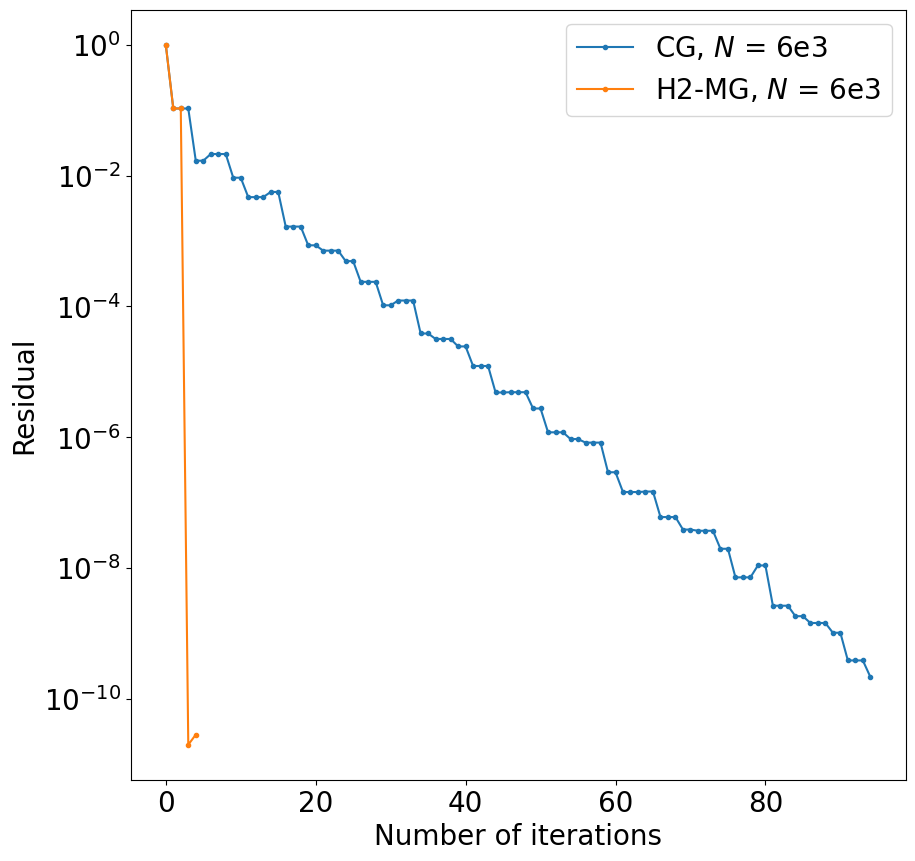

In [12]:
plot_conv(ans, [5832], time_or_iter = 'iter')

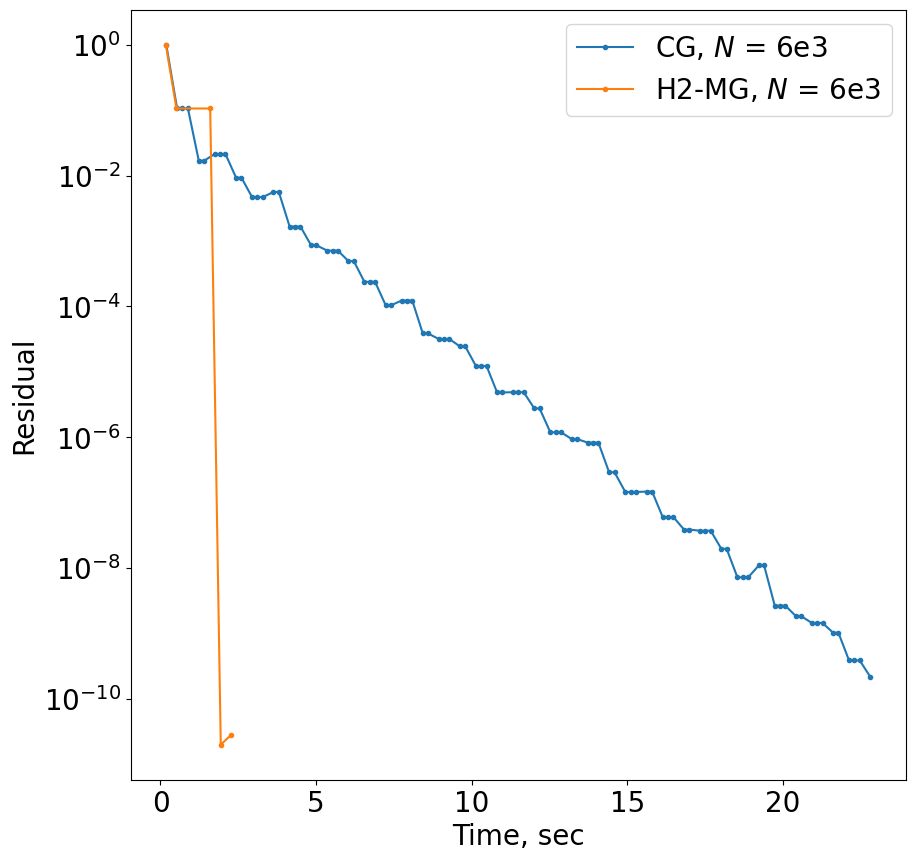

In [13]:
plot_conv(ans, [5832], time_or_iter = 'time')